### Siamese Neural Networks for One-shot Image Recognition - Face Recognition Application

##### One Shot Learning: 

One Shot Learning is all about learning to correctly make predictions given only a single example of each new
class. For this particular tasks we can use siamese neural networks - which employ a unique structure to naturally rank similarity between inputs. This Archetechture overall uses Convelutional networks for feature exttraction and similarity measurements for object/face recognitions.


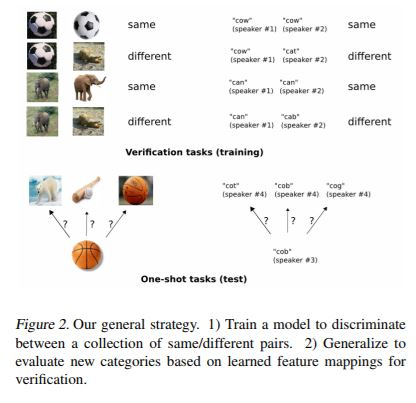

#### Import libraries

In [1]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import Activation
from keras.layers import Input, Lambda
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
import warnings
warnings.filterwarnings('ignore')

C:\Users\Sundeep\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def read_image(filename, byteorder='>'):
    
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

#### Data Source: https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html
                  	
                  Cambridge University Computer Laboratory

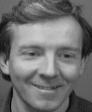

In [3]:
Image.open("att_faces\s3/1.pgm")

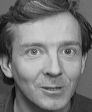

In [4]:
Image.open("att_faces\s3/10.pgm")

In [5]:
img = read_image('att_faces/s1/1.pgm')

In [6]:
img.shape

(112, 92)

### Prepare Training & Testing Data

In [7]:
#read the image
image = read_image('att_faces/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
#reduce the size
image = image[::2, ::2]
#get the new size
dim1 = image.shape[0]
dim2 = image.shape[1]

In [8]:
size = 2
total_sample_size = 10000

def get_data(size, total_sample_size):

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])  # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image('att_faces/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image('att_faces/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1
            
###########################################################################################################################

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = read_image('att_faces/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image('att_faces/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1

###########################################################################################################################

  
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

In [9]:
X, Y = get_data(size, total_sample_size)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

## Building Models

**Stage 1:** CNN for Feature extraction from the images

**Stage 2:** Distance measurements for idenfiying the similar faces

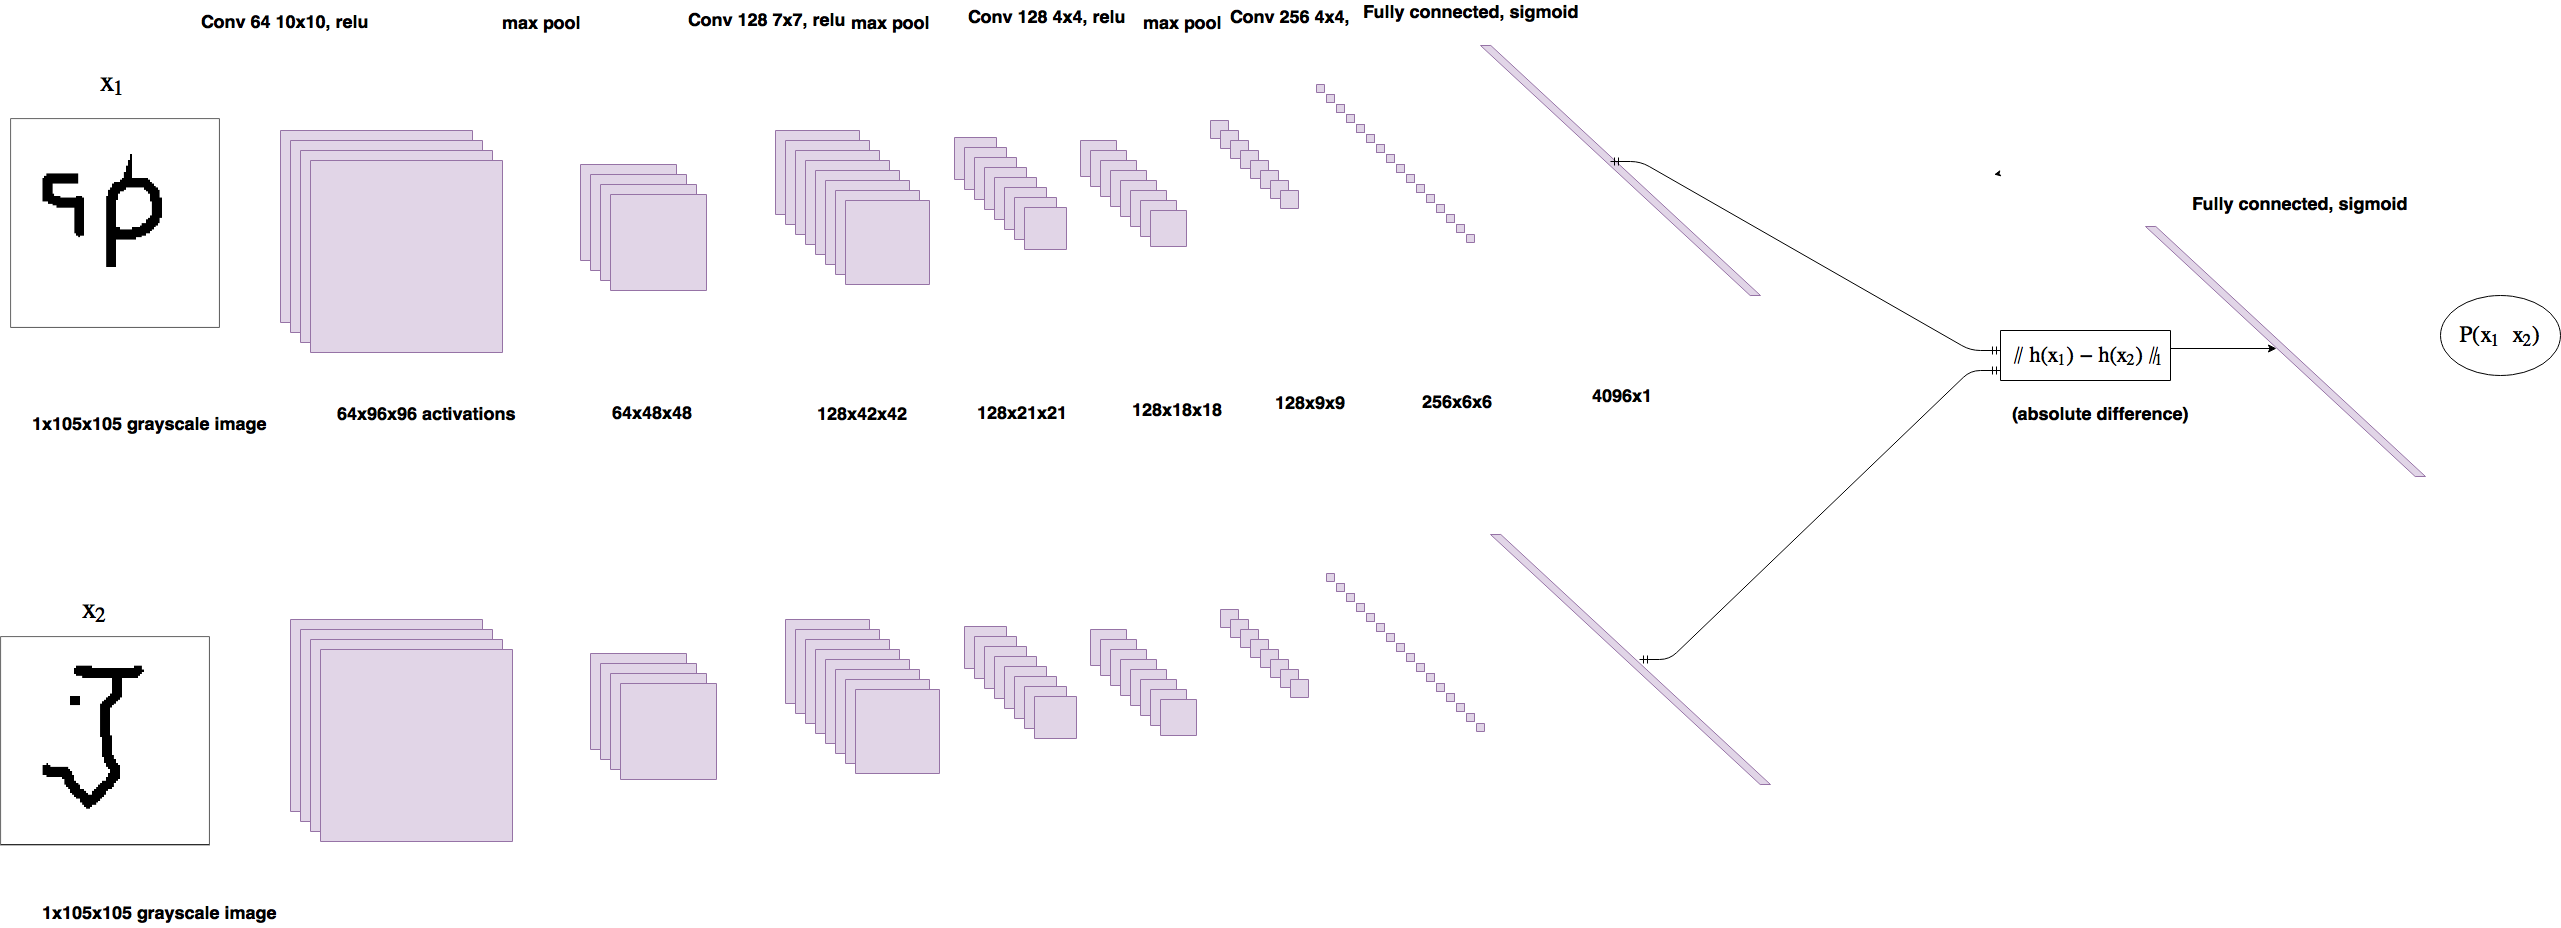

**Stage 1:** CNN for Feature extraction from the images

In [11]:
def build_base_network(input_shape):
    
    model = keras.models.Sequential()
    
    #convolutional layer 1
    model.add(keras.layers.Conv2D(6, (3, 3), input_shape=input_shape, dim_ordering='th', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))  
    model.add(keras.layers.Dropout(.25))
    
    #convolutional layer 2
    model.add(keras.layers.Conv2D(12, (3, 3), dim_ordering='th', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2))) 
    model.add(keras.layers.Dropout(.25))

    #flatten 
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, activation='relu'))
    
    print(model.summary())
    
    return model


In [12]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

In [13]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 6, 54, 44)         60        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 27, 44)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 27, 44)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 25, 42)        336       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 12, 42)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 12, 42)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3024)              0         
__________

In [14]:
x_train.shape[2:]

(1, 56, 46)

**Stage 2:** Distance measurements for idenfiying the similar faces

In [15]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [16]:
distance = Lambda(euclidean_distance)([feat_vecs_a, feat_vecs_b])

In [18]:
model = Model(input=[img_a, img_b], output=distance)

#### Defining the Loss function

Similar to the binary cross entropy function. 

If y_true is 1: Similar images than, we want to reduce the y_pred (which is the euclidean distance)

If y_true is 0: Different images than, either do not do anything if y_pred is greater than 1 else, if y_pred (distance less than 1 ) then try minimizing the 1 - y_pred.

In [19]:
def contrastive_energy_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [20]:
model.compile(loss=contrastive_energy_loss, optimizer= 'adam')

### Run the Model

In [21]:
img_1 = x_train[:, 0]
img2 = x_train[:, 1]

In [22]:
# model.fit([img_1, img2], y_train, validation_split=.25,verbose=2, epochs=13)
model.fit([img_1, img2], y_train, epochs=10)

Epoch 1/10
15000/15000 [==============================] - 55s 4ms/step - loss: 0.1291
Epoch 2/10
15000/15000 [==============================] - 56s 4ms/step - loss: 0.0681
Epoch 3/10
15000/15000 [==============================] - 49s 3ms/step - loss: 0.0530
Epoch 4/10
15000/15000 [==============================] - 48s 3ms/step - loss: 0.0450
Epoch 5/10
15000/15000 [==============================] - 48s 3ms/step - loss: 0.0388
Epoch 6/10
15000/15000 [==============================] - 48s 3ms/step - loss: 0.0336
Epoch 7/10
15000/15000 [==============================] - 48s 3ms/step - loss: 0.0296
Epoch 8/10
15000/15000 [==============================] - 49s 3ms/step - loss: 0.0255
Epoch 9/10
15000/15000 [==============================] - 51s 3ms/step - loss: 0.0221
Epoch 10/10
15000/15000 [==============================] - 48s 3ms/step - loss: 0.0196


In [23]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

### Model Evaluation

In [24]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

In [25]:
compute_accuracy(pred, y_test)

0.9763290648040357

In [26]:
x_test[:, 0][1].shape

(1, 56, 46)

In [27]:
pred[:5]

array([[1.4073944 ],
       [0.0990055 ],
       [0.08373073],
       [1.3329561 ],
       [1.2574636 ]], dtype=float32)